### Import Libraries and Load Dataset

In [1]:
import pandas as pd

# Load original dataset
df = pd.read_csv("../data/raw/healthcare_analytics_dataset.csv")

# View shape
df.shape

(500, 26)

### Check Missing Values

In [2]:
# Check for missing values
df.isnull().sum()

patient_id                   0
appointment_id               0
appointment_date             0
scheduled_date               0
no_show                      0
age                          0
gender                       0
zip_code                     0
disease_type                 0
doctor_id                    0
doctor_specialty             0
length_of_stay               0
bed_id                       0
bed_ward                     0
insurance_status             0
claim_amount                 0
claim_date                   0
covid_test_result            0
covid_test_date              0
medical_test_type            0
test_result_value            0
satisfaction_score           0
readmitted_within_30_days    0
doctor_rating                0
hospital_name                0
state                        0
dtype: int64

### Convert Date Columns

In [3]:
# Convert to datetime
df["appointment_date"] = pd.to_datetime(df["appointment_date"])
df["scheduled_date"] = pd.to_datetime(df["scheduled_date"])
df["claim_date"] = pd.to_datetime(df["claim_date"])
df["covid_test_date"] = pd.to_datetime(df["covid_test_date"])

### Feature Engineering – Time Gap Between Schedule and Appointment

In [4]:
# Days between scheduling and appointment
df["days_waiting"] = (df["appointment_date"] - df["scheduled_date"]).dt.days

# Drop any negative values (data entry issues)
df = df[df["days_waiting"] >= 0]

### Encode Binary and Categorical Columns

In [5]:
# Check which columns are still non-numeric
non_numeric_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Non-numeric columns before encoding:\n", non_numeric_cols)

Non-numeric columns before encoding:
 ['patient_id', 'appointment_id', 'no_show', 'gender', 'disease_type', 'doctor_id', 'doctor_specialty', 'bed_id', 'bed_ward', 'insurance_status', 'covid_test_result', 'medical_test_type', 'readmitted_within_30_days', 'hospital_name', 'state']


In [6]:
# Convert Yes/No columns to binary
df["no_show"] = df["no_show"].map({"Yes": 1, "No": 0})
df["readmitted_within_30_days"] = df["readmitted_within_30_days"].map(
    {"Yes": 1, "No": 0}
)

# One-hot encode all remaining object columns
df = pd.get_dummies(df, drop_first=True)

# Confirm only numeric columns remain
print("All columns after encoding are numeric:", all(df.dtypes != "object"))

All columns after encoding are numeric: True


### Drop Unnecessary Columns

In [7]:
# List of columns we want to drop (if they exist)
cols_to_drop = [
    "patient_id",
    "appointment_id",
    "scheduled_date",
    "appointment_date",
    "zip_code",
    "claim_date",
    "covid_test_date",
    "bed_id",
    "doctor_id",
    "hospital_name",
    "state",
]

# Drop only those columns that are still in the DataFrame
df_cleaned = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

### Save Cleaned Dataset

In [8]:
# Save to processed folder
df_cleaned.to_csv("../data/processed/healthcare_cleaned.csv", index=False)
print("✅ Cleaned dataset saved to /data/processed/healthcare_cleaned.csv")

✅ Cleaned dataset saved to /data/processed/healthcare_cleaned.csv


### Define X (features) and y (target)

In [9]:
# Define X and y
X = df_cleaned.drop(columns=["no_show"])
y = df_cleaned["no_show"]

# Confirm shapes
X.shape, y.shape

((500, 1251), (500,))

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((400, 1251), (100, 1251))

### Train Random Forest Model

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.76

Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        76
           1       0.00      0.00      0.00        24

    accuracy                           0.76       100
   macro avg       0.38      0.50      0.43       100
weighted avg       0.58      0.76      0.66       100



c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

### Visualize Feature Importance

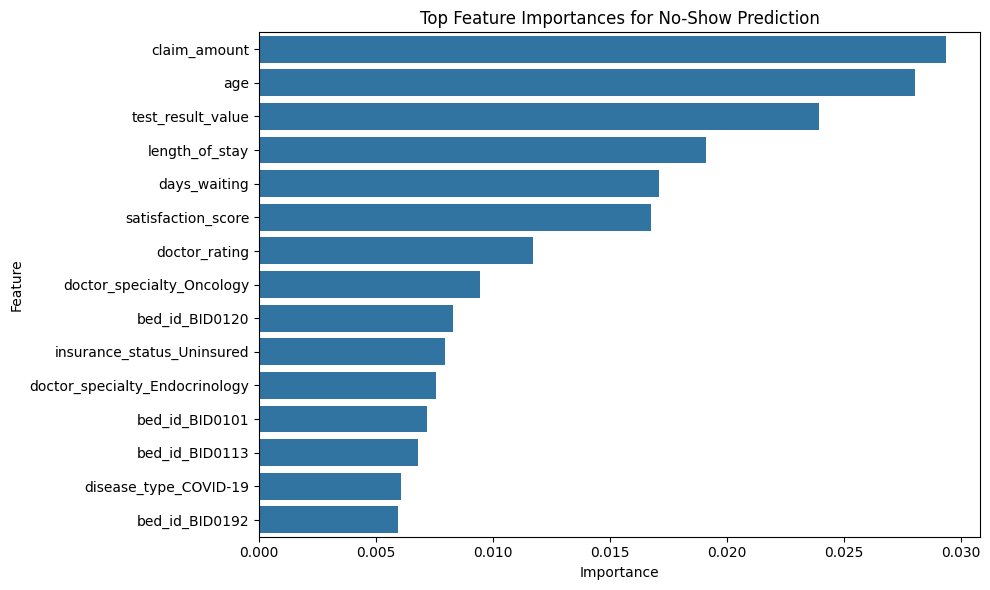

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15))
plt.title("Top Feature Importances for No-Show Prediction")
plt.tight_layout()

# Save to visuals
plt.savefig("../visuals/plots/no_show_feature_importance.png")
plt.show()

### Export Predictions to Power BI

In [13]:
# Add this after model.predict
from sklearn.metrics import accuracy_score

# Reload original data to get patient/appointment IDs
original_df = pd.read_csv("../data/raw/healthcare_analytics_dataset.csv")
original_ids = original_df.loc[
    X_test.index, ["patient_id", "appointment_id"]
].reset_index(drop=True)

# Predictions DataFrame
predictions_df = pd.concat(
    [
        original_ids,
        y_test.reset_index(drop=True).map({1: "Yes", 0: "No"}).rename("actual_no_show"),
        pd.Series(y_pred, name="predicted_no_show").map({1: "Yes", 0: "No"}),
    ],
    axis=1,
)

# Save to CSV
predictions_df.to_csv("../data/processed/cleaned/no_show_predictions.csv", index=False)
print("✅ Predictions saved to /data/processed/cleaned/no_show_predictions.csv")

✅ Predictions saved to /data/processed/cleaned/no_show_predictions.csv
